 Copyright (c) Meta Platforms, Inc. and affiliates.
 All rights reserved.
 This source code is licensed under the license found in the
 LICENSE file in the root directory of this source tree.

In [3]:
%cd ..

import pickle, json, time, os, tqdm

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader

from torchvision import transforms
from torchvision import transforms
from torchvision.transforms import functional

import faiss
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

from PIL import Image
import augly
import augly.image as imaugs

from scipy.special import betainc
import scipy.stats as stats
from scipy.stats import beta
from scipy.spatial.distance import cdist
from skimage.metrics import structural_similarity, peak_signal_noise_ratio, hausdorff_distance

from sklearn.metrics import PrecisionRecallDisplay,  precision_recall_curve, average_precision_score

import utils
import data.augment_queries

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import warnings
warnings.filterwarnings("ignore")

/private/home/pfz/02-activeindexing


## R@1 and Table 1

In [3]:
attacks = [{'attack': 'none', 'attack_param':0.0 }] \
    + [{'attack': 'contrast', 'attack_param': cf} for cf in [0.5, 2.0]] \
    + [{'attack': 'brightness', 'attack_param': bf} for bf in [0.5, 2.0]] \
    + [{'attack': 'hue', 'attack_param': 0.2}] \
    + [{'attack': 'blur', 'attack_param': 11}] \
    + [{'attack': 'jpeg', 'attack_param': 50}] \
    + [{'attack': 'rotation', 'attack_param': angle} for angle in [25,90]] \
    + [{'attack': 'center_crop', 'attack_param': 0.5}] \
    + [{'attack': 'resize', 'attack_param': 0.5}] \
    + [{'attack': 'meme_format', 'attack_param':0.0 }] \
    + [{'attack': 'auto', 'attack_param':0.0 }] 

In [4]:
paths = ["path/to/folder1/where/df/is/saved", "path/to/folder2/where/df/is/saved"]
paths = ["/checkpoint/pfz/2023_logs/0217_active_ivfpq_advanced/_active=True/", "/checkpoint/pfz/2023_logs/0217_active_ivfpq_advanced/_active=False/"]
paths = ["/checkpoint/pfz/2023_logs/0217_active_ivfpq_mixup/_active=True/", "/checkpoint/pfz/2023_logs/0217_active_ivfpq_mixup/_active=False/"]
dfs = {}
for ii, path in enumerate(paths):
    try:
        csv_path = os.path.join(path, 'retr_df.csv')
        dfs[path] = pd.read_csv(csv_path, on_bad_lines='skip') 
        dfs[path] = dfs[path].fillna(0)
    except:
        print(f"{path} is not found")

print([f"{att['attack']}, {att['attack_param']}" for att in attacks] + ["avg, 0"])
for path in paths:
    df = dfs[path]
    df.drop(columns=['ap', 'image_index', 'rank'], inplace=True)
    df = df.groupby(['attack', 'attack_param'], as_index=False).mean()
    df = df[df['attack']!='overlay_onto_screenshot']
    r1s = [df[df['attack']==att['attack']][df['attack_param']==att['attack_param']]['r@1'].values[0] for att in attacks]
    r1s.append(np.mean(r1s))
    print(f"{path} & {' & '.join([f'{r1:.2f}' for r1 in r1s])} \\\\")


['none, 0.0', 'contrast, 0.5', 'contrast, 2.0', 'brightness, 0.5', 'brightness, 2.0', 'hue, 0.2', 'blur, 11', 'jpeg, 50', 'rotation, 25', 'rotation, 90', 'center_crop, 0.5', 'resize, 0.5', 'meme_format, 0.0', 'auto, 0.0', 'avg, 0']
/checkpoint/pfz/2023_logs/0217_active_ivfpq_mixup/_active=True/ & 1.00 & 1.00 & 0.95 & 1.00 & 0.90 & 0.99 & 0.94 & 0.99 & 0.44 & 0.80 & 0.60 & 1.00 & 0.76 & 0.40 & 0.84 \\
/checkpoint/pfz/2023_logs/0217_active_ivfpq_mixup/_active=False/ & 1.00 & 0.87 & 0.66 & 0.87 & 0.54 & 0.80 & 0.65 & 0.86 & 0.38 & 0.54 & 0.48 & 0.84 & 0.50 & 0.29 & 0.66 \\


## Analyse ICD

In [4]:
# paths = ["path/to/folder1/where/icd_df/is/saved", "path/to/folder2/where/icd_df/is/saved"]
paths = ["/checkpoint/pfz/2023_logs/0217_active_ivfpq_mixup/_active=True/", "/checkpoint/pfz/2023_logs/0217_active_ivfpq_mixup/_active=False/"]

dfs = {}
for ii, path in enumerate(paths):
    csv_path = os.path.join(path, 'icd_df.csv')
    dfs[path] = pd.read_csv(csv_path, on_bad_lines='skip') 

    # load scores and retrieved_ids and convert to list of floats and ints (original is string)
    dfs[path]["scores"] = dfs[path]["scores"].apply(lambda row:[float(numb) for numb in row[1:-1].split()])
    dfs[path]["retrieved_ids"] = dfs[path]["retrieved_ids"].apply(lambda row:[int(numb) for numb in row[1:-1].split()])
    dfs[path] = dfs[path].fillna(0)

/checkpoint/pfz/2023_logs/0217_active_ivfpq_mixup/_active=True/
/checkpoint/pfz/2023_logs/0217_active_ivfpq_mixup/_active=False/


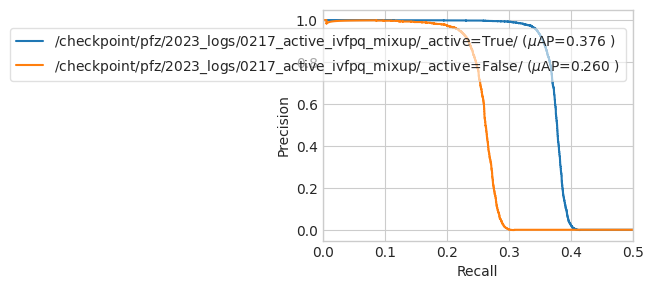

In [7]:
_, ax = plt.subplots(figsize=(4,3))

NPAIRS = 100 # number of pairs to consider for each query

for ii, path in enumerate(dfs.keys()):

    print(path)
    icd_df = dfs[path]

    # build scores and ground truth
    all_scores = icd_df["scores"].values
    all_ids = icd_df["image_index"].values
    all_retrieved_ids  = icd_df["retrieved_ids"].values

    # creating labels and score for the possible pairs
    y_labels = []
    y_scores = []

    for ii in range(len(all_scores)):
        # create NPAIRS scores and labels
        scores = all_scores[ii][:NPAIRS] 
        retrieved_ids = all_retrieved_ids[ii][:NPAIRS]

        # in the case of the IVF, when the IVF cluster contains less than NPAIRS, the retrieved id will be -1
        # we remove these cases
        if -1 in retrieved_ids:
            idx = retrieved_ids.index(-1)
            scores = scores[:idx]
            retrieved_ids = retrieved_ids[:idx]

        # scores = [-scores[jj]+scores[jj+1] for jj in range(len(scores)-1)]
        # labels = [0 if all_ids[ii] != id else 1 for id in retrieved_ids[:-1]]

        # we create the labels and scores for the pairs   
        if False:
            scores = [-score for score in scores]
            labels = [0 if all_ids[ii] != id else 1 for id in retrieved_ids]
        else: # potential score normalization
            beta = 1.0
            scores = [-scores[jj]+beta*(scores[jj+1]) for jj in range(len(scores)-1)]
            labels = [0 if all_ids[ii] != id else 1 for id in retrieved_ids[:-1]]

        # if the true match is never returned for an image originally present in the reference set, we add it with a high distance (low score)
        # this allows us to be fair in the case of the IVF, where the true match can sometimes be missing
        if icd_df['image_index'][ii]!=-1 and np.sum(labels) == 0:
            scores.append(0)
            labels.append(1)

        # add to the list
        y_labels += labels
        y_scores += scores

    # compute precision recall curve from the labels and scores
    precision = dict()
    recall = dict()
    average_precision = dict()
    precision, recall, _ = precision_recall_curve(y_labels, y_scores)
    average_precision = average_precision_score(y_labels, y_scores)
    display = PrecisionRecallDisplay(
        recall=recall,
        precision=precision
    )
    name = path
    name += " (" + r'$\mu$AP={:.3f}'.format(average_precision) + " )"
    display.plot(ax=ax, name=name)

ax.set_xlim(0, 0.5)

ax.legend(loc="upper right", bbox_to_anchor=(1.0, 0.95),  framealpha=0.6, frameon=True)
plt.show()

## Proba of failure of the IVF

In [ ]:
print('>>> Building backbone...')
model_path = "path/to/sscd/sscd_disc_mixup.torchscript.pt"
model = utils.build_backbone(path=model_path, name='custom')
model.eval()
model.to(device)

size= 288
print('>>> Building Index...')
idx_path = "path/to/idx=IVF4096,PQ8x8_quant=L2.index"
index = faiss.read_index(idx_path)
ivf_centroids = index.quantizer.reconstruct_n(0, index.nlist)
n_total = index.ntotal

fts = torch.load("path/to/ref1M/fts.pth")
index.add(fts.detach().cpu().numpy())
index.make_direct_map()
img_dir_pas = "path/to/passive/imgs/dir"
img_dir_act = "path/to/activated/imgs/dir"

default_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), transforms.Resize((size,size))])

def get_centroids(img_dir, augment=True, nmax=100):
    data_loader = utils.get_dataloader(img_dir, transform=None, batch_size=1, shuffle=False)
    rng = np.random.RandomState(0)
    centroids = []
    for ii, img in enumerate(tqdm.tqdm(data_loader)):
        pil_img = img[0]
        if augment:
            attacked_img, aug_params = augment_queries.augment_img(pil_img, rng, return_params=True)
        else:
            attacked_img = pil_img
        attacked_img = default_transform(attacked_img).unsqueeze(0).to(device)
        ft = model(attacked_img)
        ft = ft.detach().cpu().numpy()

        ivf_D, ivf_I = index.quantizer.search(ft, k=1)
        centroids.append(ivf_I[0][0])

        if ii >= nmax:
            break
    return centroids

centroids_pas = get_centroids(img_dir_pas, augment=True, nmax=10000)
centroids_act = get_centroids(img_dir_act, augment=True, nmax=10000)
centroids_gt = get_centroids(img_dir_pas, augment=False, nmax=10000)
print('pf_ivf : ', np.mean([el1 ==el2 for el1, el2 in zip(centroids_pas, centroids_gt)]))
print('pf_ivf : ', np.mean([el1 ==el2 for el1, el2 in zip(centroids_act, centroids_gt)]))

## Reconstruction errors

In [ ]:
print('>>> Building backbone...')
model_path = "path/to/sscd/sscd_disc_mixup.torchscript.pt"
model = utils.build_backbone(path=model_path, name='custom')
model.eval()
model.to(device)

size= 288
print('>>> Building Index...')
idx_path = "path/to/idx=IVF4096,PQ8x8_quant=L2.index"
index = faiss.read_index(idx_path)
ivf_centroids = index.quantizer.reconstruct_n(0, index.nlist)
n_total = index.ntotal

fts = torch.load("path/to/ref1M/fts.pth")
index.add(fts.detach().cpu().numpy())
index.make_direct_map()
def get_dists(img_dir, transform, n_max = 1000):
    dists_1 = []
    dists_2 = []
    ct=0
    default_transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    for img_name in tqdm.tqdm(os.listdir(img_dir)):
        img_path = os.path.join(img_dir, img_name)
        if 'attack' in img_name:
            continue
        pil_img = Image.open(img_path)
        img = transform(pil_img).unsqueeze(0).to(device)
        img = functional.resize(img, (size,size))
        
        # create ft and add
        ft = model(img).detach().cpu().numpy()
        if index.ntotal < n_total + n_max:
            index.add(ft)
            index.make_direct_map()

        img = default_transform(pil_img).unsqueeze(0).to(device)
        img = functional.resize(img, (size,size))
        ft_ori = model(img).detach().cpu().numpy()

        # recons
        pq_recons = index.reconstruct(n_total+ct)
        dist = np.linalg.norm(ft-pq_recons)
        dists_1.append(dist)

        # cluster
        ivf_D, ivf_I = index.quantizer.search(ft_ori, k=1)
        centroid = ivf_centroids.take(ivf_I.flatten(), axis=0)
        dist = np.linalg.norm(ft-centroid)
        dists_2.append(dist)

        ct += 1
        if ct >= n_max:
            break
    return np.array(dists_1), np.array(dists_2)
    
n_max = 10000

print('>>> Computing distances...')

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

img_dir_pas = "path/to/passive/imgs/dir"
img_dir_act = "path/to/activated/imgs/dir"

dists_ref, dists_ivf_ref = get_dists(img_dir_pas,transform, n_max=n_max)
dists_act, dists_ivf_act= get_dists(img_dir_act,transform, n_max=n_max)

print('>>> Computing distances for with hue shift...')
transform = transforms.Compose([
    lambda x: functional.adjust_contrast(x, 2.0),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

t_dists_ref, t_dists_ivf_ref = get_dists(img_dir_pas,transform, n_max=n_max)
t_dists_act, t_dists_ivf_act= get_dists(img_dir_act,transform, n_max=n_max)


def get_dists_nonmatching(data_loader, n_max = 100):
    ct=0
    fts = []
    pqs = []
    for img in tqdm.tqdm(data_loader):
        img = img.to(device)
        ft = model(img).detach().cpu().numpy()
        fts.append(ft)
        ct += ft.shape[0]
        if ct >= n_max:
            break
    fts = np.concatenate(fts, axis=0)
    pq_recons = index.reconstruct_n(0, n_max)
    dists = cdist(fts, pq_recons, metric='euclidean')
    dists = dists[~np.eye(dists.shape[0],dtype=bool)].reshape(dists.shape[0],-1)
    return dists.flatten()

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Resize((size,size)),
    ])

data_loader = utils.get_dataloader(img_dir_pas, transform, batch_size=128, collate_fn=None)
dists_nonmatching = get_dists_nonmatching(data_loader, n_max = 128)

data_loader = utils.get_dataloader(img_dir_act, transform, batch_size=128, collate_fn=None)
dists_nonmatching_act = get_dists_nonmatching(data_loader, n_max = 128)

dists_ref = np.array(dists_ref)
print(np.mean(dists_ref**2), np.std(dists_ref**2))
t_dists_ref = np.array(t_dists_ref)
print(np.mean(t_dists_ref**2), np.std(t_dists_ref**2))
dists_act = np.array(dists_act)
print(np.mean(dists_act**2), np.std(dists_act**2))
t_dists_act = np.array(t_dists_act)
print(np.mean(t_dists_act**2), np.std(t_dists_act**2))
dists_nonmatching = np.array(dists_nonmatching)
print(np.mean(dists_nonmatching**2), np.std(dists_nonmatching**2))
dists_nonmatching_act = np.array(dists_nonmatching_act)
print(np.mean(dists_nonmatching_act**2), np.std(dists_nonmatching_act**2))
dists_ref = np.array(dists_ref)**2
t_dists_ref = np.array(t_dists_ref)**2
dists_act = np.array(dists_act)**2
t_dists_act = np.array(t_dists_act)**2
dists_nonmatching = np.array(dists_nonmatching)**2
dists_nonmatching_act = np.array(dists_nonmatching_act)**2
import scipy.stats as stats
plt.rc('text', usetex=False)

cmap = plt.get_cmap('tab10')
colors = cmap.colors

fig, axs = plt.subplots(2, 1, figsize=(4, 3.5), sharex=True, sharey=True)

axs[0].axvline(dists_ref.mean(), linestyle='dashed', linewidth=1, color=colors[0], alpha=0.8)
axs[0].axvline(t_dists_ref.mean(), linestyle='dashed', linewidth=1, color=colors[1], alpha=0.8)
axs[0].axvline(dists_nonmatching.mean(), linestyle='dashed', linewidth=1, color=colors[2], alpha=0.8)
axs[0].hist(dists_nonmatching, bins=100, label=r'$||y-q(x)||^2$', density=True, color=colors[2], alpha=0.4)
axs[0].hist(dists_ref, bins=100, label=r'$||x-q(x)||^2$', density=True, color=colors[0], alpha=0.8)
axs[0].hist(t_dists_ref, bins=100, label=r'$||\hat{x}-q(x)||^2$', density=True, color=colors[1], alpha=0.8)
axs[0].set_title('Passive')

axs[1].axvline(dists_ref.mean(), linestyle='dashed', linewidth=1, color=colors[0], alpha=0.2)
axs[1].axvline(t_dists_ref.mean(), linestyle='dashed', linewidth=1, color=colors[1], alpha=0.2)
axs[1].axvline(dists_act.mean(), linestyle='dashed', linewidth=1, color=colors[0], alpha=0.8)
axs[1].axvline(t_dists_act.mean(), linestyle='dashed', linewidth=1, color=colors[1], alpha=0.8)
axs[1].axvline(dists_nonmatching_act.mean(), linestyle='dashed', linewidth=1, color=colors[2], alpha=0.8)
axs[1].hist(dists_nonmatching_act, bins=100, label=r'$||y^\star-q(x)||^2$', density=True, color=colors[2], alpha=0.4)
axs[1].hist(dists_act, bins=100, label=r'$||x^\star-q(x)||^2$', density=True, color=colors[0], alpha=0.8)
axs[1].hist(t_dists_act, bins=100, label=r'$||\hat{x}^\star-q(x)||^2$', density=True, color=colors[1], alpha=0.8)
axs[1].set_title('Active')

axs[0].legend(framealpha=0.6, frameon=True, loc='upper left')
axs[1].legend(framealpha=0.6, frameon=True, loc='upper right')
axs[0].grid()
axs[1].grid()
plt.tight_layout()
plt.yticks([])
plt.xlim(0.5,1.4)
plt.show()
print(dists_ref.mean(), t_dists_ref.mean(), dists_act.mean(), t_dists_act.mean())

## Time

In [2]:
def search_times(idx_path, nqueries=10000):
    print(idx_path)
    index = faiss.read_index(idx_path)
    fts_reference_path = "path/to/ref_1M/fts.pth"
    fts = torch.load(fts_reference_path)
    index.add(fts.detach().cpu().numpy())
    n_index_ref = index.ntotal
    if 'IVF' in idx_path:
        index.make_direct_map()

    np.random.seed(0)
    fts = np.random.randn(nqueries, 512).astype(np.float32)

    nprobes = [1,16,32]
    if not 'IVF' in idx_path:
        nprobes = [1]

    for nprobe in nprobes:
        index.nprobe = nprobe
        search_times = []
        for ii in range(nqueries):
            ft = fts[ii:ii+1]
            time_0 = time.time()
            index.search(ft, k=1)
            search_times.append(time.time() - time_0)
        search_times = 1e3 * np.array(search_times)
        print(f'Averaged search time: {np.mean(search_times)} - Max: {np.max(search_times)} - Min: {np.min(search_times)} - Std: {np.std(search_times)}')

In [ ]:
search_times("path/to/index.index")

## Images

### Qualitative

In [ ]:
def psnr(x):
    return 20*np.log10(255) - 10*np.log10(np.mean(x**2))

def visu_diff(img_ori, img_comp, title=None, figsize=(20,30), crop=None, hori=True):
    plt.figure(figsize=figsize)
    if title is not None:
        plt.suptitle(title, fontsize=16)
        
    img_ori_ar = np.asarray(img_ori)
    img_comp_ar = np.asarray(img_comp)

    if hori:
        plt.subplot(1, 3, 1)    
    else:
        plt.subplot(3, 1, 1)
    plt.imshow(img_ori_ar)
    plt.axis('off')
    plt.title('Image 1')

    if hori:
        plt.subplot(1, 3, 2)    
    else:
        plt.subplot(3, 1, 2)
    plt.imshow(img_comp_ar)
    plt.axis('off')
    plt.title('Image 2')

    diff = img_comp_ar.astype(int)-img_ori_ar.astype(int)
    print("Linf = %i" %np.amax(np.abs(diff)), ' at ', np.unravel_index(np.argmax(np.abs(diff), axis=None), np.abs(diff).shape))
    print("PSNR = %f" %psnr(diff))
    diff = np.linalg.norm(diff, ord=1, axis=2)
    if hori:
        plt.subplot(1, 3, 3)    
    else:
        plt.subplot(3, 1, 3)
    plt.imshow(diff)
    plt.title('Difference')

    plt.tight_layout()
    plt.axis('off')
    plt.grid(False)
    plt.show()

    return diff

### Quantitative

In [ ]:
ori_img_dir = "path/to/original/img/dir"
img_dir = "path/to/activated/img/dir"

filenames = os.listdir(ori_img_dir)
filenames.sort()
psnrs = []
ssims = []
linfs = []
for ii, filename in enumerate(filenames):
    if ii > 1000:
        break
    pil_img_ori = Image.open(os.path.join(ori_img_dir, filename))
    pil_img = Image.open(os.path.join(img_dir, f'{ii:05d}.png'))
    img_ori = np.asarray(pil_img_ori)
    img = np.asarray(pil_img)
    print(img_ori.shape, img.shape, filename, f'{ii:05d}.png')
    ssims.append(structural_similarity(img_ori, img, channel_axis=2))
    psnrs.append(peak_signal_noise_ratio(img_ori, img))
    linfs.append(np.amax(np.abs(img_ori.astype(int)-img.astype(int))))
    if ssims[-1]<0.9:
        print(filename)

In [ ]:
ssim_mean, ssim_std, ssim_max, ssim_min = np.mean(ssims), np.std(ssims), np.max(ssims), np.min(ssims) 
psnr_mean, psnr_std, psnr_max, psnr_min = np.mean(psnrs), np.std(psnrs), np.max(psnrs), np.min(psnrs)
linf_mean, linf_std, linf_max, linf_min = np.mean(linfs), np.std(linfs), np.max(linfs), np.min(linfs)
print(f"SSIM: {ssim_mean:.4f}±{ssim_std:.4f} [{ssim_min:.4f}, {ssim_max:.4f}]")
print(f"PSNR: {psnr_mean:.4f}±{psnr_std:.4f} [{psnr_min:.4f}, {psnr_max:.4f}]")
print(f"Linf: {linf_mean:.4f}±{linf_std:.4f} [{linf_min:.4f}, {linf_max:.4f}]")